In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import zipfile
import os
import re
import glob
import tqdm
import csv
import io
import ast
from PIL import Image, ImageDraw

# **Download data from Kaggle + data generators**

In [2]:
! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 1.6MB/s 
    100% |████████████████████████████████| 245kB 5.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [3]:
! KAGGLE_USERNAME=herrhellana KAGGLE_KEY=e86b811fa8c902f6e90dbab3dbe4136c kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

100% 7.37G/7.37G [01:35<00:00, 106MB/s]
100% 7.37G/7.37G [01:35<00:00, 82.9MB/s]


In [0]:
# open zip file
zf = zipfile.ZipFile("train_simplified.zip")

In [5]:
# create a list of class labels
class_labels = list(map(lambda x: x.replace(".csv", ""), zf.namelist()))
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
  while True:
    with io.TextIOWrapper(zf.open(fn)) as f:
      f.readline()  # skip header
      for line in csv.reader(f, delimiter=',', quotechar='"'):
        yield line[1], line[5] # need only `drawing` and `word` variables from each .csv file
        if debug:
          print(fn, "is done, starting from the beginning...")

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        if debug:
          print("Random_indices = {} \n".format(random_indices))
          print("Random_generators = {} \n".format(generators[random_indices]))
        yield [next(gen) for gen in generators[random_indices]]

# Image generators



In [0]:
# faster conversion function
def draw_it(strokes, img_size=224):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((img_size, img_size))
    return np.array(image, dtype=np.uint8)

In [0]:
def images_and_labels_generator(batch_size, img_size=224):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0], img_size))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [10]:
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
NUM_CLASSES = len(class_labels)

In [0]:
#### NB! train_iterator for non-augmented images
################################################
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        # images normalization:
        images = (batch[0])/255 - 0.5 # (x - np.min(x))/(np.max(x) - np.min(x)), min=0, max=255
        images = np.expand_dims(images, -1) # shape we should get = [num_images, 224, 224, 1]
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

# Saving epochs in your Drive

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [15]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
# import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + list(filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT)))[0]
print(GOOGLE_DRIVE_ROOT)

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model_{}"
print(CHECKPOINT_TEMPLATE)

/content/gdrive/My Drive
/content/gdrive/My Drive/model_{}


# Last ARCH

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
! pip install livelossplot

In [0]:
from keras.layers import LeakyReLU
from livelossplot import PlotLossesKeras

In [0]:
IMG_SIZE = 224

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(Conv2D(8, (3, 3), padding='same', kernel_initializer = "glorot_normal", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.15))
    
    model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer = "glorot_normal"))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.45))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [23]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 8)       80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 8)       32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 224, 224, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
__________

In [0]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = 110
EPOCHS = 200

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

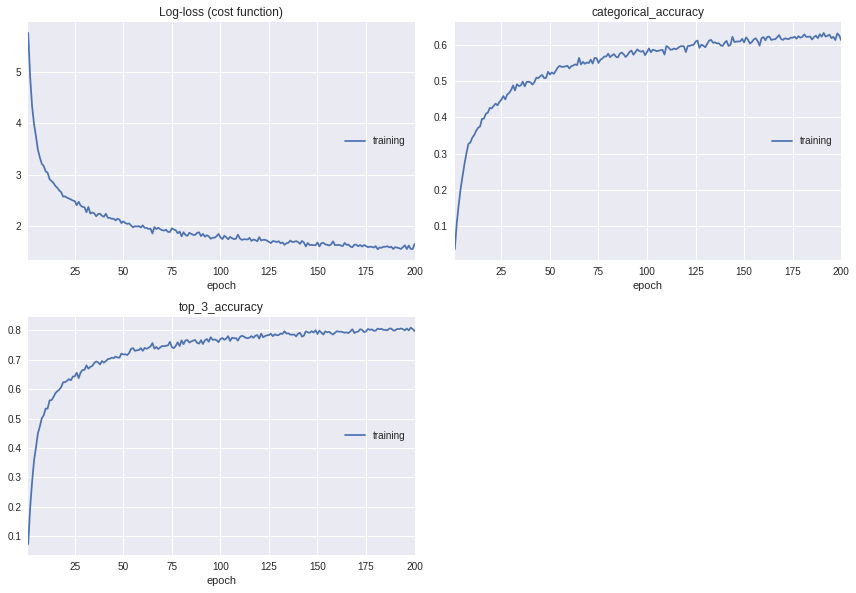

In [25]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=0
)

In [0]:
# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 200
# model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

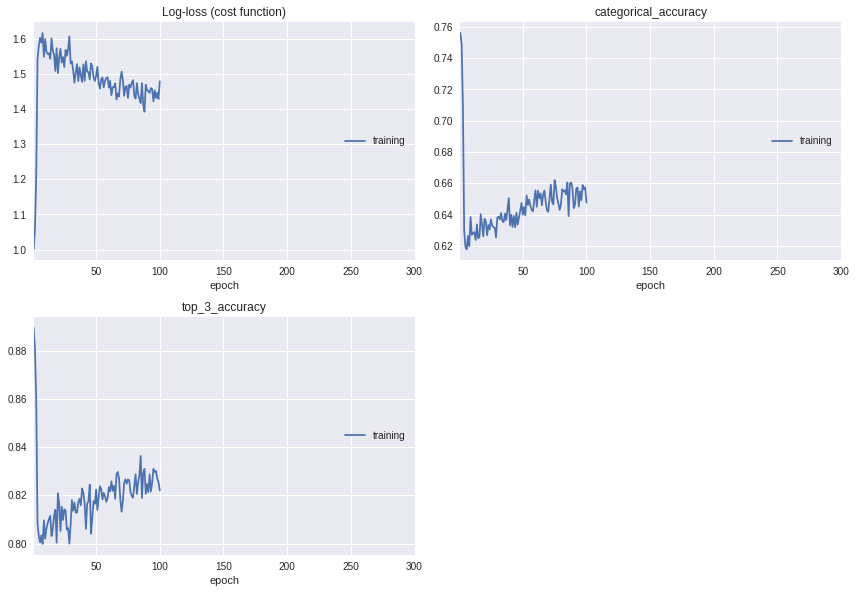

In [30]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=300,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE), PlotLossesKeras()],
    verbose=1,
    initial_epoch=200
)

# Score test

In [31]:
# download test set
! KAGGLE_USERNAME=herrhellana KAGGLE_KEY=e86b811fa8c902f6e90dbab3dbe4136c kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 76% 45.0M/59.0M [00:00<00:00, 46.9MB/s]
100% 59.0M/59.0M [00:00<00:00, 98.4MB/s]


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                ### YOUR CODE HERE: normalize batch_images the same way as during training!
                batch_images = batch_images/255 - 0.5
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            ### YOUR CODE HERE: normalize batch_images the same way as during training!
            batch_images = batch_images/255 - 0.5
            yield batch_keys, batch_images

In [35]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [36]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 1754/1754.0 [05:55<00:00,  5.68it/s]


In [37]:
! wc -l submission.csv

112200 submission.csv


In [38]:
# submit to kaggle
! KAGGLE_USERNAME=herrhellana KAGGLE_KEY=e86b811fa8c902f6e90dbab3dbe4136c kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.45M/4.45M [00:09<00:00, 480kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge